<a href="https://colab.research.google.com/github/anvibhagavathula/CNN-Kernel/blob/main/4_model_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4. Convert PyTorch Model to TFLite**

## 4.0 Setup GDrive and Git

### Import GitHub dependencies and mount Google Drive
You should now see your GitHub files under the folder icon to the left. Make sure to include your own token.

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-anvibhagavathula' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-anvibhagavathula
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### Install required packages

In [5]:
# Install ONNX
!pip3 install onnx

# Install tensorflow-addons
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

# Install onnx-tensorflow
!git clone https://github.com/onnx/onnx-tensorflow.git
!cd onnx-tensorflow && pip3 install -e .
# NOTE THERE IS A BUG. If you try and fail to import onnx_tf then just restart
# your runtime after cloning the repo and it should work!

!pip3 install torchaudio


fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
Obtaining file:///content/gdrive/MyDrive/ece5545/onnx-tensorflow
  Preparing metadata (setup.py) ... done
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.10.0
    Uninstalling onnx-tf-1.10.0:
      Successfully uninstalled onnx-tf-1.10.0
  Running setup.py develop for onnx-tf


### Import code dependencies

In [6]:
# Import libraries
import sys,os

# Add path to onnx-tensorflow
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'onnx-tensorflow'))
sys.path.insert(0, PROJECT_ROOT)

import onnx
import torch
import torch.nn as nn
import numpy as np
import os
import tensorflow as tf
print(f"TensorFlow Version is: {tf.__version__}")
from onnx_tf.backend import prepare

# Import constants to use constants defined for training
from src.constants import *
import src.data_proc as data_proc

TensorFlow Version is: 2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 4.1 Define the Model


**Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left.

In [7]:
!ls {TORCH_DIR}

fp32_checkpoint.pt  tinyconv_float32_init_seed0_88.01%_0.pt


Please use a checkpoint from the cell above and place it in the cell below for the `torch_path`

In [8]:
from src.networks import TinyConv
import os.path as osp

# Create audio processor
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR) # DATASET_DIR is defined in constants

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a full precision (float32) TinyConv model
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)
model_fp32.to(device)

# TODO: Replace me!
torch_path = osp.join(TORCH_DIR, "tinyconv_float32_init_seed0_88.01%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

## 4.2 Convert from PyTorch to TFLite
This is the last step before deploying your model to your TinyML device.

In [9]:
from src.train_val_test_utils import choose_name
# Choose a path
# You can also define your own path
file_name = choose_name("temp")

The model's will be stored as: 
 temp_0


### Convert to ONNX

In [11]:
# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(model_fp32.cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file

tf_rep.export_graph(TF_PATH)

### Convert to TFLite

In [12]:
FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'float_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'quant_{file_name}.tflite')

float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

Float model is 69288 bytes
Quantized model is 20000 bytes


Notice how the quantized model is less than a third of the size of the float model? We'll next see how this reduction in size affects model accuracy.

### TFLite Model Accuracy

In [13]:
# Helper function to run inference
def run_tflite_inference_test_set(tflite_model_path, model_type="Float"):
    # Load test data
    test_data, test_labels = audio_processor.get_data(
          -1, 0, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
          TIME_SHIFT_MS, 'testing')
    test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # For quantized models, manually quantize the input data from float to integer
    if model_type == "Quantized":
        input_scale, input_zero_point = input_details["quantization"]
        test_data = test_data / input_scale + input_zero_point
        test_data = test_data.astype(input_details["dtype"])

    # Evaluate the predictions
    correct_predictions = 0
    for i in range(len(test_data)):
        interpreter.set_tensor(input_details["index"], test_data[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        top_prediction = output.argmax()
        correct_predictions += (top_prediction == test_labels[i])

    print('%s model accuracy is %f%% (Number of test samples=%d)' % (
        model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [14]:
# Compute float model accuracy
run_tflite_inference_test_set(FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
run_tflite_inference_test_set(MODEL_TFLITE, model_type='Quantized')

Float model accuracy is 88.523392% (Number of test samples=1368)
Quantized model accuracy is 88.742691% (Number of test samples=1368)


As you can see, quantizing the model hardly affects the model accuracy in this case and makes it much more easily deployable to a tiny machine.

We will now create the byte version of our model needed for deployment.

**Replace the name of file in MODEL_TFLITE with the *quant* model you saved earlier in this notebook.**

You can find the name of your file in "{PROJECT_ROOT}/models/tflite_models" under the folder icon to the left.

### TFLite Micro Conversion

In [15]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/quant_temp_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,914 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,076 kB]
Get:13 http://security.ubuntu.com/ubuntu ja

You can find the below bites in the "{PROJECT_ROOT}/models/micro_models" folder. If you do not see an output after the next cell, make sure you replaced the file name  of {MODEL_TFLITE} in the cell above with your quant model created earlier in this notebook.

In [16]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x78, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00, 0xc0, 0x43, 0x00, 0x00,
  0xd0, 0x43, 0x00, 0x00, 0x5c, 0x4d, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x56, 0xbb, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xa4, 0xff, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x12, 0xbc, 0xff, 0xff,
  0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x69, 0x6e, 0x00, 0x00,
  0x02, 0x

### Hand in: Profile running time and plot the breakdown between preprocessing, neural network, and post-processing on arduino

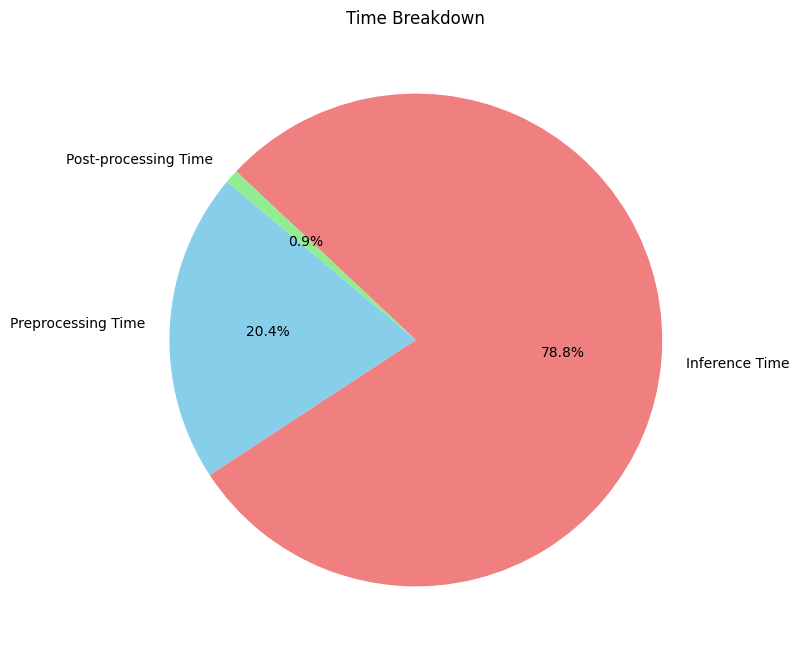

In [17]:
import matplotlib.pyplot as plt

# Numbers recorded on Arduino IDE
labels = ['Preprocessing Time', 'Inference Time', 'Post-processing Time']
times = [23, 89, 1]
plt.figure(figsize=(8, 8))
plt.pie(times, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Time Breakdown')
plt.show()